***Participantes (RM - NOME):***<br>
339624 - Camila<br>
339656 - Cleiton<br>
340214 - Henrique<br>
339708 - Roberto<br>
340192 - Sergio<br>

## **Criar um classificador de sentimento aplicando técnicas de PLN**
---

Utilizando o dataset de revisões de filmes em português [1], criar um classificador de sentimentos que consiga um score na métrica F1 Score superior a 70%.

Devem utilizar uma amostra de 20% e randon_state igual a 42 para testar as implementações e mensurar a métrica F1 Score (usar o parâmetro average = 'weighted') o restante dos dados devem ser utilizados para o treinamento (80%).

Fique a vontade para testar os métodos de pré-processamento, abordagens, algoritmos e bibliotecas, mas explique e justifique suas decisões.
O trabalho poderá ser feito em grupo de até 4 pessoas (mesmo grupo do Startup One).

Separe a implementação do seu modelo campeão junto com a parte de validação/teste de forma que o professor consiga executar todo o pipeline do modelo campeão.

Composição da nota:
- 50% - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, etc.)
- 50% - Baseado na performance obtida com o dataset de teste (conforme recomendação da amostra) no seu modelo campeão e na validação que o professor processar (Métrica F1 Score).

[1] - https://dados-ml-pln.s3-sa-east-1.amazonaws.com/reviews-pt-br.csv

# Bibliotecas utilizadas

In [13]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import wordcloud as wd
import re
from collections import Counter

import spacy

import nltk
from nltk.stem.rslp import RSLPStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pydot


In [2]:
sb.set_theme(context='notebook', style='whitegrid')

nlp = spacy.load('pt_core_news_md')
rslp = RSLPStemmer()

In [4]:
print(tf.__version__)
#print(keras.__version__)
print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
True
Num GPUs Available:  1


# Funções externas

In [3]:
# função de lematização completa do documento
def stemmer_text(frase):
  tokens = [rslp.stem(w) for w in frase.split()]
  return " ".join(tokens)

# função de lematização completa do documento
def lemmatizer_text(frase):
  doc = nlp(frase)
  tokens = [w.lemma_ for w in doc]
  return " ".join(tokens)

# função de lematização para os verbos do documento
def lemmatizer_verbs(frase):
  doc = nlp(frase)
  tokens = [w.lemma_ if w.pos_ == 'VERB' else w.text for w in doc]
  return " ".join(tokens)

def plural_singular(palavra):
  r2 = r"ses$|zes$|res$"
  r3 = r"ões$|ães$"
  r4 = r"ais$|éis$|óis$|uis$"
  r5 = r"is$"
  r6 = r"eis$"
  if palavra.endswith('s'):
    if re.findall(r2, palavra):
      return palavra[:-2]
    if re.findall(r3, palavra):
      return palavra[:-3] + "ão"
    if re.findall(r4, palavra):
      return palavra[:-2] + "l"
    if re.findall(r5, palavra):
      return palavra[:-1] + "l"
    if re.findall(r6, palavra):
      return palavra[:-1] + "il"
    if palavra.endswith('ns'):
      return palavra[:-2] + "m"
    return palavra[:-1]
  return palavra  

def pre(frase):
  regex = r"[`,.?:;!&\"]"
  palavras = frase.split()
  palavras = [p.lower() for p in palavras if p not in stops]
  palavras = [re.sub(regex, "", p) for p in palavras]
  palavras = [p for p in palavras if len(p) >= 3]
  palavras = [p for p in palavras if not p.isnumeric()]
  palavras = [plural_singular(p) for p in palavras]

  return " ".join(palavras)

In [6]:
t = "quantas vezes vamos ter de esperar para poder saber o que é amar ricardo"

d = nlp(t)
for w in d:
    print(w.text, w.pos_, w.lemma_, w.dep_)

quantas DET quanto det
vezes NOUN vezar obl
vamos AUX ir dep
ter VERB ter ROOT
de SCONJ de mark
esperar VERB esperar xcomp
para SCONJ parir case
poder VERB poder obl
saber VERB saber xcomp
o PRON o det
que PRON que ccomp
é AUX ser cop
amar VERB amar ccomp
ricardo NOUN ricardo obj


# Carregando os Dados

In [7]:
df = pd.read_csv('./data/reviews-pt-br.csv', encoding='utf-8')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44514 entries, 0 to 44513
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   codigo      44514 non-null  int64 
 1   texto       44514 non-null  object
 2   sentimento  44514 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [9]:
df.head(10)

,codigo,texto,sentimento
0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg
1,2,O Bravo parece indicar que o personagem princi...,neg
2,3,"Durante a Guerra pela Independência do Sul, GE...",pos
3,4,É fora de questão que a verdadeira Anna Anders...,pos
4,5,Concordo totalmente com outro dos revisores aq...,neg
5,6,Obra-prima absoluta de um filme! Boa noite Mr....,pos
6,7,Embora a palavra megalmania seja muito usada p...,pos
7,8,Esta tem que ser a peça mais incrível de porca...,neg
8,9,Eu suponho que todas as piadas internas são o ...,neg
9,10,"Se há um tema deste filme, é que as pessoas po...",pos


## Conferindo se temos dados nulos ou duplicados

In [10]:
df.isna().sum()

codigo        0
texto         0
sentimento    0
dtype: int64

In [11]:
df[df.duplicated()].count()

codigo        0
texto         0
sentimento    0
dtype: int64

## Distribuição das respostas

In [12]:
df.groupby('sentimento').count()

,codigo,texto
sentimento,,
neg,22307,22307
pos,22207,22207


In [13]:
# em percentual
round(df.groupby('sentimento').count().texto / df.shape[0] * 100, 2)

sentimento
neg    50.11
pos    49.89
Name: texto, dtype: float64

<AxesSubplot:xlabel='sentimento', ylabel='count'>

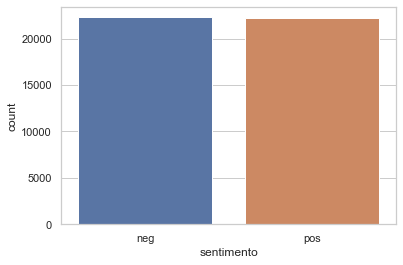

In [14]:
sb.countplot(x=df.sentimento)

## Criando o conjunto de stopwords (NLTK + SPACY)

In [4]:
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
stopwords_spacy = nlp.Defaults.stop_words
stops = list(set(stopwords_spacy).union(stopwords_nltk))
print(sorted(stops))

['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'diante', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dão', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'en

# Analisando o conjunto total das palavras

In [16]:
# exemplo de críticas no nosso dataframe
print(df.texto[0])
print("-" * 40)
print(df.texto[1536])
print("-" * 40)
print(df.texto[8192])

Esse bocejo de pia de cozinha de orçamento muito baixo é o tipo de filme que só pode ser feito no Reino Unido porque, em qualquer outro lugar do mundo, o mercado precisaria existir antes que fosse dada uma luz verde. Provavelmente auto-financiado, esta é claramente uma tentativa de corrigir questões importantes, mas enfraquece seu ponto de vista em que a questão precisa ser colocada, quem colocaria dinheiro para distribuir isso e, em segundo lugar, se uma audiência de mercado não existe para assistir, comprar ou alugar este filme, por que alguém se incomodaria em primeiro lugar? Minhas opiniões podem soar injustamente severas para um diretor de primeira viagem, mas esse é o tipo de filme que só vai minar a viabilidade comercial e os padrões de qualidade que apenas mantiveram uma indústria cinematográfica britânica. Avaliado em Edimburgo. 2 de 10.
----------------------------------------
Ambientada em Paris no ano de 1910, uma antiga e rica cantora de ópera decide entregar sua fortuna a

In [17]:
# criando um texto completo com todas as críticas
texto_completo = " ".join([texto for texto in df.texto])
texto_completo_pos = " ".join([texto for texto in df[df.sentimento == 'pos'].texto])
texto_completo_neg = " ".join([texto for texto in df[df.sentimento == 'neg'].texto])

In [77]:
print("QTD de todas as palvaras", len(texto_completo.split()))
print("QTD de todas as palvaras das críticas positivas", len(texto_completo_pos.split()))
print("QTD de todas as palvaras das críticas negativas", len(texto_completo_neg.split()))

QTD de todas as palvaras 9843831
QTD de todas as palvaras das críticas positivas 4923191
QTD de todas as palvaras das críticas negativas 4920640


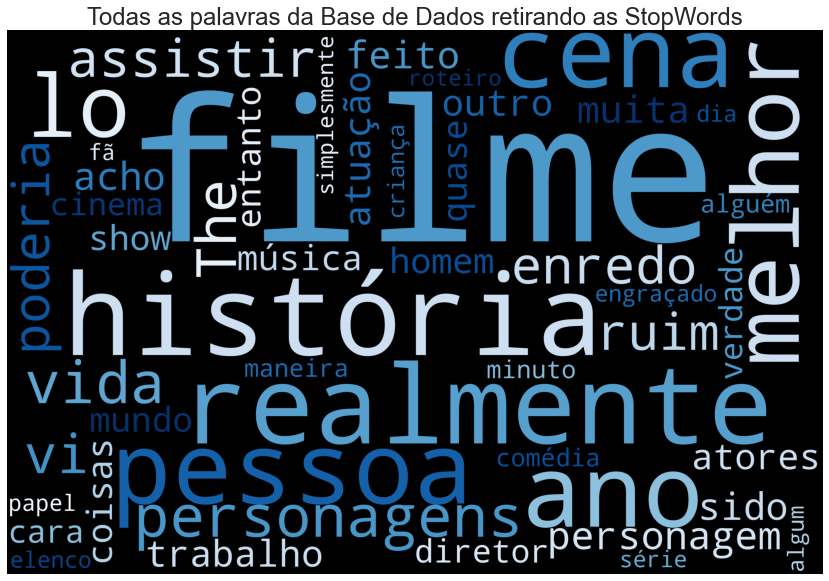

In [35]:
# criando uma wordcloud de todas as palavra sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo)

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras da Base de Dados retirando as StopWords", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

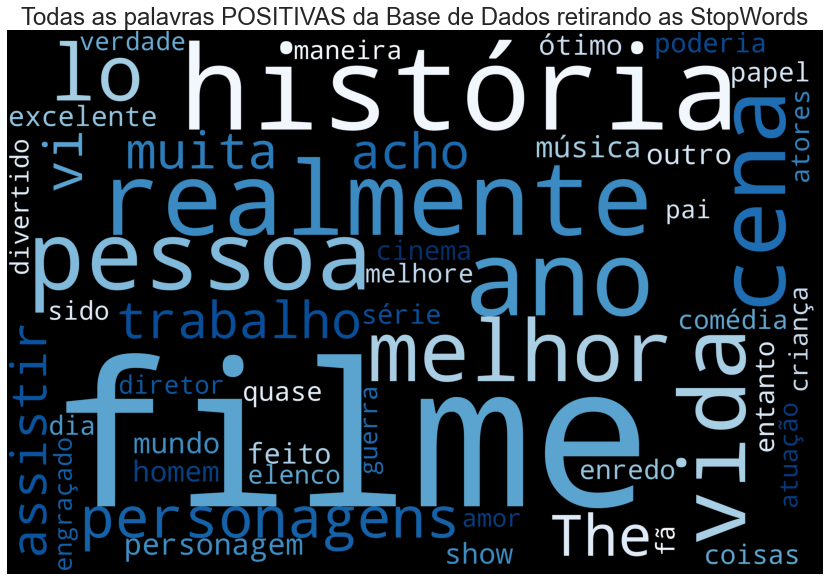

In [36]:
# criando uma wordcloud de todas as palavra sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo_pos)

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras POSITIVAS da Base de Dados retirando as StopWords", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

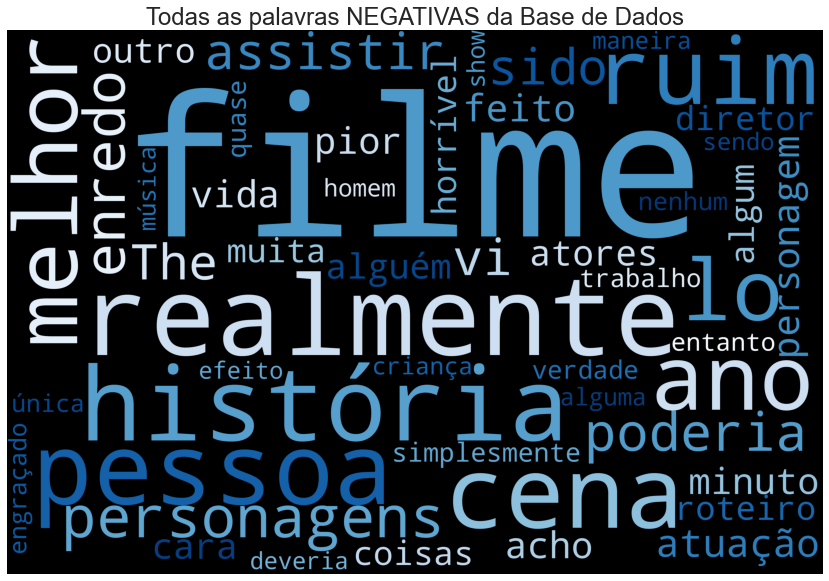

In [23]:
# criando uma wordcloud de todas as palavra sem as stopwords
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False, stopwords = stops).generate(texto_completo_neg)

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras NEGATIVAS da Base de Dados retirando as StopWords", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

## Criando uma função de pré processamento

In [17]:
palavras = texto_completo.split()
len(palavras)

9843831

In [18]:
# retirando as stopwords das palavras
palavras = [p.lower() for p in palavras if p not in stops]
len(palavras)

5057320

In [19]:
# retirando pontuações das palavras
regex = r"[`,.?:;!&\"]"
palavras = [re.sub(regex, "", p) for p in palavras]
len(palavras)

5057320

In [20]:
#retirando palavras menores que 3 caracteres
palavras = [p for p in palavras if len(p) >= 3]
len(palavras)

4646563

In [21]:
# retirando os números das palavras
palavras = [p for p in palavras if not p.isnumeric()]
len(palavras)

4632358

In [22]:
#convertendo as palavras para o singular
palavras = [plural_singular(p) for p in palavras]
len(palavras)

4632358

## Criamos uma função chamada "pre" que iremos usar em nossas análises dos modelos

# Vamos analisar quais palavras são comuns as críticas negativas e positivas

In [45]:
todas_palavras_pos = texto_completo_pos.split()
todas_palavras_pos = [pre(w) for w in todas_palavras_pos]
todas_palavras_pos = [w for w in todas_palavras_pos if w != '']
ctpp = Counter()
ctpp.update(todas_palavras_pos)
ctpp.most_common(50)

[('filme', 79424),
 ('história', 13496),
 ('melhor', 11453),
 ('ele', 11133),
 ('personagem', 11108),
 ('ano', 10869),
 ('realmente', 10253),
 ('este', 9098),
 ('pessoa', 8975),
 ('cena', 8603),
 ('vida', 8095),
 ('isso', 8044),
 ('ma', 6458),
 ('the', 6282),
 ('não', 5981),
 ('homem', 5813),
 ('ator', 5463),
 ('outro', 5173),
 ('trabalho', 5073),
 ('muita', 5009),
 ('acho', 4725),
 ('assistir', 4628),
 ('coisa', 4518),
 ('música', 4459),
 ('mundo', 4330),
 ('show', 4211),
 ('tempo', 4161),
 ('feito', 4157),
 ('ótimo', 4083),
 ('excelente', 3967),
 ('diretor', 3938),
 ('você', 3817),
 ('jovem', 3775),
 ('entanto', 3749),
 ('poderia', 3746),
 ('enredo', 3718),
 ('série', 3709),
 ('cinema', 3698),
 ('ela', 3627),
 ('quase', 3610),
 ('real', 3587),
 ('papel', 3563),
 ('comédia', 3541),
 ('mulher', 3531),
 ('dia', 3476),
 ('atuação', 3464),
 ('bom', 3457),
 ('sido', 3438),
 ('elenco', 3437),
 ('maneira', 3409)]

In [46]:
todas_palavras_neg = texto_completo_neg.split()
todas_palavras_neg = [pre(w) for w in todas_palavras_neg]
todas_palavras_neg = [w for w in todas_palavras_neg if w != '']
ctpn = Counter()
ctpn.update(todas_palavras_neg)
ctpn.most_common(50)

[('filme', 87835),
 ('realmente', 12175),
 ('personagem', 11443),
 ('isso', 11007),
 ('ruim', 10363),
 ('não', 10301),
 ('história', 10286),
 ('ele', 10202),
 ('cena', 9894),
 ('pessoa', 9889),
 ('melhor', 9165),
 ('este', 8769),
 ('ano', 8029),
 ('ma', 6934),
 ('ator', 6425),
 ('poderia', 6368),
 ('enredo', 6361),
 ('pior', 6212),
 ('assistir', 5706),
 ('sido', 5596),
 ('atuação', 5469),
 ('coisa', 5390),
 ('the', 5266),
 ('feito', 4940),
 ('vida', 4875),
 ('outro', 4867),
 ('algum', 4742),
 ('acho', 4717),
 ('diretor', 4686),
 ('minuto', 4603),
 ('cara', 4467),
 ('homem', 4375),
 ('alguém', 4265),
 ('você', 4205),
 ('bem', 4095),
 ('então', 3970),
 ('horrível', 3959),
 ('roteiro', 3930),
 ('mulher', 3856),
 ('simplesmente', 3841),
 ('muita', 3841),
 ('tempo', 3772),
 ('quase', 3769),
 ('disso', 3721),
 ('alguma', 3669),
 ('verdade', 3624),
 ('que', 3564),
 ('por', 3551),
 ('bom', 3521),
 ('trabalho', 3515)]

In [73]:
%%time
p = ctpp.most_common()
n = ctpn.most_common()
r = [[x for x in p if x[0] == y[0]] for y in n]
r = [x for x in r if len(x) != 0]
len(r)

48663

In [102]:
palavras_comuns = [w[0][0] for w in r]
palavras_comuns[:100]

['filme',
 'realmente',
 'personagem',
 'isso',
 'ruim',
 'não',
 'história',
 'ele',
 'cena',
 'pessoa',
 'melhor',
 'este',
 'ano',
 'ma',
 'ator',
 'poderia',
 'enredo',
 'pior',
 'assistir',
 'sido',
 'atuação',
 'coisa',
 'the',
 'feito',
 'vida',
 'outro',
 'algum',
 'acho',
 'diretor',
 'minuto',
 'cara',
 'homem',
 'alguém',
 'você',
 'bem',
 'então',
 'horrível',
 'roteiro',
 'mulher',
 'simplesmente',
 'muita',
 'tempo',
 'quase',
 'disso',
 'alguma',
 'verdade',
 'que',
 'por',
 'bom',
 'trabalho',
 'como',
 'entanto',
 'nenhum',
 'original',
 'única',
 'engraçado',
 'show',
 'real',
 'principal',
 'sendo',
 'criança',
 'ação',
 'maneira',
 'deveria',
 'efeito',
 'música',
 'interessante',
 'cinema',
 'diálogo',
 'mundo',
 'dinheiro',
 'suficiente',
 'ela',
 'problema',
 'comédia',
 'terror',
 'tudo',
 'provavelmente',
 'elenco',
 'terrível',
 'dia',
 'hora',
 'mim',
 'fato',
 'amigo',
 'sentido',
 'casa',
 'mal',
 'vez',
 'livro',
 'durante',
 'série',
 'garota',
 'completa

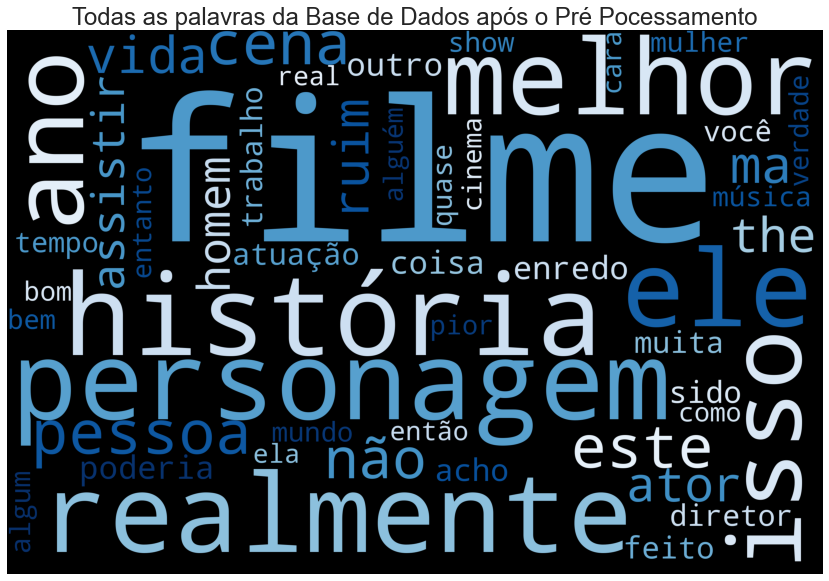

In [87]:
# criando uma wordcloud das palavras filtradas
wordcloud = wd.WordCloud(width = 3000, height = 2000, max_words=50, random_state=42, background_color='black', colormap='Blues', collocations=False).fit_words(dict(ctp))

plt.figure(figsize=(20, 10))
plt.title("Todas as palavras da Base de Dados após o Pré Pocessamento", fontdict={'fontsize':24})
plt.imshow(wordcloud) 
plt.axis("off");
plt.show()

## Criando as colunas tratadas

In [25]:
%%time
#df['stem'] = df.texto.apply(stemmer_text)

Wall time: 0 ns


In [26]:
%time
#df['lemm'] = df.texto.apply(lemmatizer_text)

Wall time: 0 ns


In [27]:
%%time
#df['verb'] = df.texto.apply(lemmatizer_verbs)

Wall time: 0 ns


In [28]:
%%time
#df['pre'] = df.texto.apply(pre)

Wall time: 0 ns


In [5]:
#df.to_csv("./data/criticas.csv")
df = pd.read_csv('../criticas.csv')

In [9]:
df.head(10)

,Unnamed: 0,codigo,texto,sentimento,stem,lemm,verb,pre
0,0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg,ess bocej de pia de co de orç muit baix é o ti...,Esse bocejar de pio de cozinhar de orçamentar ...,Esse bocejo de pia de cozinha de orçamento mui...,esse bocejo pia cozinha orçamento filme feito ...
1,1,2,O Bravo parece indicar que o personagem princi...,neg,"o brav parec indic que o person principal, cla...",O Bravo parecer indicar que o personagem princ...,O Bravo parecer indicar que o personagem princ...,bravo indicar personagem principal claro coraj...
2,2,3,"Durante a Guerra pela Independência do Sul, GE...",pos,"dur a guerr pel independ do sul, gener spanky ...","Durante o Guerra pelar Independência do Sul , ...","Durante a Guerra pela Independência do Sul , G...",durante guerra independência sul general spank...
3,3,4,É fora de questão que a verdadeira Anna Anders...,pos,é for de quest que a verd ann anderson não era...,É ser de questão que o verdadeiro Anna Anderso...,É fora de questão que a verdadeira Anna Anders...,verdadeira anna anderson princesa anastasia al...
4,4,5,Concordo totalmente com outro dos revisores aq...,neg,concord total com outr do revi aqu que fic sat...,Concordo totalmente com outro dos revisor aqui...,Concordo totalmente com outro dos revisores aq...,concordo totalmente outro revisor ficou satisf...
5,5,6,Obra-prima absoluta de um filme! Boa noite Mr....,pos,obra-pr absolut de um filme! boa noit mr.tom r...,Obra-prima absoluto de um filmar ! Boa noite M...,Obra-prima absoluta de um filme ! Boa noite Mr...,obra-prima absoluta filme boa noite mrtom rapi...
6,6,7,Embora a palavra megalmania seja muito usada p...,pos,emb a palavr megalman sej muit us par descrev ...,Embora o palavra megalmania ser muito usar par...,Embora a palavra megalmania seja muito usar pa...,embora palavra megalmania usada descrever gene...
7,7,8,Esta tem que ser a peça mais incrível de porca...,neg,est tem que ser a peç mais incr de porc cinema...,Esta ter que ser o pedir mais incrível de porc...,Esta tem que ser a peça mais incrível de porca...,esta peça incrível porcaria cinematográfica as...
8,8,9,Eu suponho que todas as piadas internas são o ...,neg,eu suponh que tod as pi intern são o que fez d...,Eu supor que todo o piar interno ser o que faz...,Eu supor que todas as piadas internas são o qu...,suponho piada interna munchie clássico cult pe...
9,9,10,"Se há um tema deste filme, é que as pessoas po...",pos,"se há um tem dest filme, é que as pesso pod li...","Se haver um temer dar filmar , ser que o pesso...","Se haver um tema deste filme , ser que as pess...",tema filme pessoa lidar dificuldade imaginação...


In [107]:
stops2 = set(stops).union(palavras_comuns[:100])
len(stops2)

579

# Dividindo a base em treino e teste

In [10]:
# dividindo com 20% para o treino e random state = 42
df_treino, df_teste = train_test_split(
      df, 
      test_size = 0.2, 
      random_state = 42
  )

In [11]:
# distribuição das respostas do treino em %
round(df_treino.groupby('sentimento').count() / df.shape[0] * 100, 2).texto

sentimento
neg    40.07
pos    39.93
Name: texto, dtype: float64

In [12]:
# distribuição das respostas do teste em %
round(df_teste.groupby('sentimento').count() / df.shape[0] * 100, 2).texto

sentimento
neg    10.04
pos     9.96
Name: texto, dtype: float64

# Criando o primeiro modelo com árvore de decisão

In [97]:
%%time
# vetorização em unigramas com CountVectorizer
vect = CountVectorizer(ngram_range=(1,1)) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7139
F1 Score: 0.7139
Wall time: 1min 19s


In [109]:
%%time
# vetorização em unigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(1,1), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")


Acuracidade: 0.7266
F1 Score: 0.7266
Wall time: 1min 5s


In [38]:
%%time
# vetorização em unigramas com CountVectorizer e pré processamento
vect = CountVectorizer(ngram_range=(1,1)) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.pre)
vect_treino = vect.transform(df_treino.pre)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.pre)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7274
F1 Score: 0.7274
Wall time: 1min 4s


In [40]:
%%time
# vetorização em unigramas com CountVectorizer, sem stopwords e Stemmização
vect = CountVectorizer(ngram_range=(1,1), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.stem)
vect_treino = vect.transform(df_treino.stem)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.stem)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7
F1 Score: 0.7
Wall time: 1min 11s


In [41]:
%%time
# vetorização em unigramas com CountVectorizer, sem stopwords e Lemmatização
vect = CountVectorizer(ngram_range=(1,1), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.lemm)
vect_treino = vect.transform(df_treino.lemm)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.lemm)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7168
F1 Score: 0.7168
Wall time: 1min 2s


In [42]:
%%time
# vetorização em unigramas com CountVectorizer, sem stopwords e Lemmatização de verbos
vect = CountVectorizer(ngram_range=(1,1), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.verb)
vect_treino = vect.transform(df_treino.verb)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.verb)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7182
F1 Score: 0.7182
Wall time: 1min 5s


## Vamos continuar a analise com a base pre processada e original sem stop words

## Testando o TFIDF

In [30]:
%%time
# vetorização em unigramas com TfIdf e sem stopwords
vect = TfidfVectorizer(ngram_range=(1,1), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7134
F1 Score: 0.7134
Wall time: 1min 12s


In [31]:
%%time
# vetorização em unigramas com TfIdf e pré processamento
vect = TfidfVectorizer(ngram_range=(1,1)) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.pre)
vect_treino = vect.transform(df_treino.pre)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.pre)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7086
F1 Score: 0.7086
Wall time: 1min 5s


## Observamos um melhor resultado com o CountVectorizer

## Testando modelos com Bigramas

In [38]:
%%time
# vetorização em unigramas + Bigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(1,2), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7366
F1 Score: 0.7366
Wall time: 7min 8s


In [33]:
%%time
# vetorização em bigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(2,2), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7264
F1 Score: 0.7261
Wall time: 12min 2s


In [34]:
%%time
# vetorização em unigramas + bigramas com CountVectorizer e pré processamento
vect = CountVectorizer(ngram_range=(1,2)) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.pre)
vect_treino = vect.transform(df_treino.pre)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.pre)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7244
F1 Score: 0.7244
Wall time: 7min 11s


In [35]:
%%time
# vetorização em bigramas com CountVectorizer e pré processamento
vect = CountVectorizer(ngram_range=(2,2)) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.pre)
vect_treino = vect.transform(df_treino.pre)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.pre)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7255
F1 Score: 0.7251
Wall time: 12min 4s


## Testando modelo com Trigramas usando o melhor modelo com Bigramas

In [113]:
%%time
# vetorização em unigramas + Bigramas + Trigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(1,3), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

## Como não houve melhora vamos continuar com Unigramas + Bigramas

In [13]:
%%time
# vetorização em unigramas + Bigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(1,2), stop_words=stops)#, min_df=10, max_df=0.95) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7366
F1 Score: 0.7366
Wall time: 7min 28s


In [16]:
%%time
# vetorização em unigramas + Bigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(1,2), stop_words=stops, min_df=10) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7356
F1 Score: 0.7356
Wall time: 1min 24s


In [17]:
%%time
# vetorização em unigramas + Bigramas com CountVectorizer e sem stopwords
vect = TfidfVectorizer(ngram_range=(1,2), stop_words=stops, min_df=10) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.714
F1 Score: 0.714
Wall time: 1min 26s


In [20]:
%%time
# vetorização em unigramas + Bigramas com CountVectorizer e sem stopwords
vect = HashingVectorizer(ngram_range=(1,2), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

# treinamento do modelo árvore de decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.7156
F1 Score: 0.7156
Wall time: 4min 18s


# Random Forest

In [38]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,2), stop_words=stops, min_df=10) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

Wall time: 19.3 s


In [39]:
%%time
# treinamento do modelo Árvore Aleatória
tree = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.858
F1 Score: 0.858
Wall time: 37.7 s


In [41]:
%%time
# vetorização em unigramas sem stopwords
vect = TfidfVectorizer(ngram_range=(1,2), stop_words=stops, min_df=10) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

Wall time: 19.5 s


In [42]:
%%time
# treinamento do modelo árvore de decisão
tree = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.8549
F1 Score: 0.8548
Wall time: 36 s


In [43]:
%%time
# vetorização em unigramas sem stopwords
vect = CountVectorizer(ngram_range=(1,2), stop_words=stops, min_df=10) 
# utilizando a base completa sem ajustes
vect.fit(df_treino.texto)
vect_treino = vect.transform(df_treino.texto)

Wall time: 20.2 s


In [45]:
%%time
# treinamento do modelo árvore de decisão
tree = AdaBoostClassifier(n_estimators=200, random_state=42)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.8306
F1 Score: 0.8306
Wall time: 44.4 s


In [46]:
%%time
# treinamento do modelo árvore de decisão
tree = BaggingClassifier(n_estimators=200, random_state=42, n_jobs=-1)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.801
F1 Score: 0.801
Wall time: 29min 42s


In [47]:
%%time
# treinamento do modelo árvore de decisão
tree = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
tree.fit(vect_treino, df_treino.sentimento)

# escoragem da classificação na amostra de teste
vect_teste = vect.transform(df_teste.texto)
predito = tree.predict(vect_teste)

# mensuração do resultado pela acurácia e f1 score
accuracy = accuracy_score(df_teste.sentimento, predito)
f1score = f1_score(df_teste.sentimento, predito, average='weighted')

print(f"Acuracidade: {round(accuracy,4)}")
print(f"F1 Score: {round(f1score,4)}")

Acuracidade: 0.876
F1 Score: 0.876
Wall time: 58.5 s


# MLP

In [6]:
df.head()

,Unnamed: 0,codigo,texto,sentimento,stem,lemm,verb,pre
0,0,1,Esse bocejo de pia de cozinha de orçamento mui...,neg,ess bocej de pia de co de orç muit baix é o ti...,Esse bocejar de pio de cozinhar de orçamentar ...,Esse bocejo de pia de cozinha de orçamento mui...,esse bocejo pia cozinha orçamento filme feito ...
1,1,2,O Bravo parece indicar que o personagem princi...,neg,"o brav parec indic que o person principal, cla...",O Bravo parecer indicar que o personagem princ...,O Bravo parecer indicar que o personagem princ...,bravo indicar personagem principal claro coraj...
2,2,3,"Durante a Guerra pela Independência do Sul, GE...",pos,"dur a guerr pel independ do sul, gener spanky ...","Durante o Guerra pelar Independência do Sul , ...","Durante a Guerra pela Independência do Sul , G...",durante guerra independência sul general spank...
3,3,4,É fora de questão que a verdadeira Anna Anders...,pos,é for de quest que a verd ann anderson não era...,É ser de questão que o verdadeiro Anna Anderso...,É fora de questão que a verdadeira Anna Anders...,verdadeira anna anderson princesa anastasia al...
4,4,5,Concordo totalmente com outro dos revisores aq...,neg,concord total com outr do revi aqu que fic sat...,Concordo totalmente com outro dos revisor aqui...,Concordo totalmente com outro dos revisores aq...,concordo totalmente outro revisor ficou satisf...


In [7]:
df_mlp = df[['texto', 'pre']].copy()
df_mlp['target'] = [0 if x == 'pos' else 1 for x in df.sentimento]
df_mlp.head()

,texto,pre,target
0,Esse bocejo de pia de cozinha de orçamento mui...,esse bocejo pia cozinha orçamento filme feito ...,1
1,O Bravo parece indicar que o personagem princi...,bravo indicar personagem principal claro coraj...,1
2,"Durante a Guerra pela Independência do Sul, GE...",durante guerra independência sul general spank...,0
3,É fora de questão que a verdadeira Anna Anders...,verdadeira anna anderson princesa anastasia al...,0
4,Concordo totalmente com outro dos revisores aq...,concordo totalmente outro revisor ficou satisf...,1


In [8]:
# dividindo com 20% para o treino e random state = 42
df_treino_mlp, df_teste_mlp = train_test_split(
      df_mlp, 
      test_size = 0.2, 
      random_state = 42
  )
df_mlp.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44514 entries, 0 to 44513
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   44514 non-null  object
 1   pre     44514 non-null  object
 2   target  44514 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [51]:
# distribuição das respostas do treino em %
round(df_treino_mlp.groupby('target').count() / df_mlp.shape[0] * 100, 2).texto

target
0    39.93
1    40.07
Name: texto, dtype: float64

In [52]:
# distribuição das respostas do teste em %
round(df_teste_mlp.groupby('target').count() / df_mlp.shape[0] * 100, 2).texto

target
0     9.96
1    10.04
Name: texto, dtype: float64

In [12]:
t = Tokenizer()
t.fit_on_texts(df_mlp.pre)

In [76]:
t.document_count

44514

In [129]:
encoded_docs = t.texts_to_matrix(df_mlp.pre, mode='count')
encoded_docs.shape

(44514, 118880)

In [9]:
# vetorização em unigramas + Bigramas com CountVectorizer e sem stopwords
vect = CountVectorizer(ngram_range=(1,2), stop_words=stops, min_df=50) 
#vect = CountVectorizer(ngram_range=(1,1), stop_words=stops) 
# utilizando a base completa sem ajustes
vect.fit(df_treino_mlp.pre)
vect_treino = vect.transform(df_treino_mlp.pre)

In [10]:
vect_treino

<35611x9919 sparse matrix of type '<class 'numpy.int64'>'
	with 2645691 stored elements in Compressed Sparse Row format>

In [11]:
X = vect_treino.toarray()
X.shape

(35611, 9919)

In [12]:
y = df_treino_mlp.target.values.reshape(-1,1)
y.shape

(35611, 1)

In [44]:
#Modelo da Rede MLP
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               992000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 997,101
Trainable params: 997,101
Non-trainable params: 0
_________________________________________________________________
None


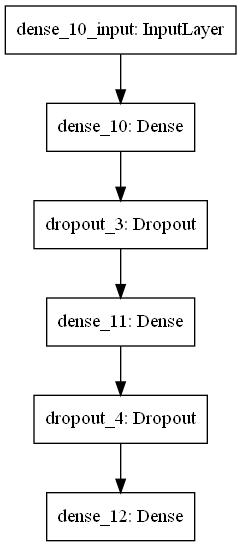

In [47]:
plot_model(model)

In [48]:
%%time
#Processo de treinamento com 80% dos dados
history  = model.fit(X, y, epochs=5, validation_split=0.3, batch_size=2)

Epoch 1/5
12464/12464 [==============================] - 45s 4ms/step - loss: 0.3608 - accuracy: 0.8494 - val_loss: 0.3097 - val_accuracy: 0.8724
Epoch 2/5
12464/12464 [==============================] - 45s 4ms/step - loss: 0.2113 - accuracy: 0.9170 - val_loss: 0.3531 - val_accuracy: 0.8757
Epoch 3/5
12464/12464 [==============================] - 47s 4ms/step - loss: 0.1065 - accuracy: 0.9610 - val_loss: 0.4887 - val_accuracy: 0.8710
Epoch 4/5
12464/12464 [==============================] - 46s 4ms/step - loss: 0.0463 - accuracy: 0.9853 - val_loss: 0.7038 - val_accuracy: 0.8675
Epoch 5/5
12464/12464 [==============================] - 46s 4ms/step - loss: 0.0278 - accuracy: 0.9926 - val_loss: 0.9379 - val_accuracy: 0.8618
Wall time: 3min 51s


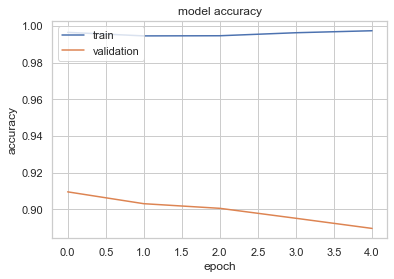

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

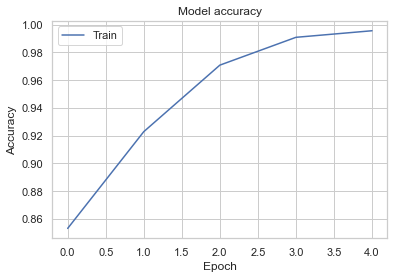

In [38]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
vect_teste = vect.transform(df_teste_mlp.pre)
X_teste = vect_teste.toarray()
X_teste.shape

(8903, 9919)

In [40]:
y_teste = df_teste_mlp.target.values.reshape(-1,1)
y_teste.shape

(8903, 1)

In [94]:
#Processo de teste com 30% dos dados que não foram utilizados no treinamento
y_pred_classes  = model.predict_classes(X_teste)
y_pred_classes

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [41]:
scores = model.evaluate(X_teste, y_teste)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

279/279 [==============================] - 1s 3ms/step - loss: 0.9520 - accuracy: 0.8602

accuracy: 86.02%


#### **Validação do professor**

Consolidar apenas os scripts do seu **modelo campeão**, desde o carregamento do dataframe, separação das amostras, tratamentos utilizados (funções, limpezas, etc.), criação dos objetos de vetorização dos textos e modelo treinado e outras implementações utilizadas no processo de desenvolvimento do modelo.